# **GPU required. Please open this notebook in the Colab**

<a href="https://colab.research.google.com/github/apssouza22/computer-vision/blob/master/zd-face-transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transforming images using StyleGan2

In this lab we are going to learn how to create a latent vector from an image and use the StyleGan to transform the image. This is the approach used to generate a old version of your face.

<img src="images/myself.jpg" width="300" style="display:inline">
<img src="images/ex-myself-transformed.png" width="300" style="display:inline">

References :
-  https://colab.research.google.com/github/pbaylies/stylegan-encoder/blob/master/StyleGAN_Encoder_Tutorial.ipynb#scrollTo=JAy5VqXW7xRI
-  https://github.com/pbaylies/stylegan-encoder
- https://github.com/tr1pzz/InterFaceGAN


In [1]:
# Loading dependency projects

!git clone https://github.com/apssouza22/computer-vision.git
!git clone https://github.com/rolux/stylegan2encoder.git


Cloning into 'computer-vision'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 205 (delta 0), reused 3 (delta 0), pack-reused 200
Receiving objects: 100% (205/205), 56.36 MiB | 42.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Cloning into 'stylegan2encoder'...
remote: Enumerating objects: 111, done.
remote: Total 111 (delta 0), reused 0 (delta 0), pack-reused 111
Receiving objects: 100% (111/111), 1.55 MiB | 44.10 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [1]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Extracts and aligns faces

Face should be the only element in the image. Extracting faces from the image and saving those in the sampel_faces folder

In [3]:
import sys
sys.path.insert(0, "/content/stylegan2encoder")
import os
import bz2
from keras.utils import get_file
from ffhq_dataset.face_alignment import image_align
from ffhq_dataset.landmarks_detector import LandmarksDetector

LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'


def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

def align_image(raw_img_path):
    """
    Extracts and aligns all faces from images using DLib and a function from original FFHQ dataset preparation step
    """

    landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2', LANDMARKS_MODEL_URL, cache_subdir='temp'))
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    for i, face_landmarks in enumerate(landmarks_detector.get_landmarks(raw_img_path), start=1):
        image_align(raw_img_path, 'sample_faces/aligned-face.png', face_landmarks)

In [4]:
os.makedirs("sample_faces", exist_ok=True)
align_image("computer-vision/images/myself.jpg")

## Generating latent representation of the image

Embedding a given image into the latent space of StyleGAN. This embedding enables semantic image editing operations that can be applied to existing photographs. 

In [6]:
import pretrained_networks
import projector
import shutil
from stylegan2encoder.project_images import project_image
from stylegan2encoder.project_images import render_video

# Defining params
args = {}
args['src_dir'] ='sample_faces/'
args['dst_dir'] = 'generated_images/'
args['tmp_dir'] = '.stylegan2-tmp'
args['network_pkl'] = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
args['vgg16_pkl'] = 'https://drive.google.com/uc?id=1N2-m9qszOeVC9Tq77WxsLnuWwOedQiD2'
args['num_steps'] = 1000
args['initial_learning_rate'] = 0.1
args['initial_noise_factor'] = 0.05
args['verbose'] = True
args['video'] = True
args['video_mode'] = 1
args['video_size'] = 1024
args['video_fps'] = 25
args['video_codec'] = 'libx264'
args['video_bitrate'] = '5M'

In [7]:
print('Loading networks from "%s"...' % args['network_pkl'])

_G, _D, Gs = pretrained_networks.load_networks(args['network_pkl'])
proj = projector.Projector(
    vgg16_pkl             = args['vgg16_pkl'],
    num_steps             = args['num_steps'],
    initial_learning_rate = args['initial_learning_rate'],
    initial_noise_factor  = args['initial_noise_factor'],
    verbose               = args['verbose']
)
proj.set_network(Gs)

def generate_latent(args):
  src_files = sorted([os.path.join(args['src_dir'], f) for f in os.listdir(args['src_dir']) if f[0] not in '._'])

  for src_file in src_files:
      project_image(proj, src_file, args['dst_dir'], args['tmp_dir'], video=args['video'])
      if args['video']:
          render_video(
              src_file, args['dst_dir'], args['tmp_dir'], args['num_steps'], args['video_mode'],
              args['video_size'], args['video_fps'], args['video_codec'], args['video_bitrate']
          )
      shutil.rmtree(args['tmp_dir'])


Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Projector: Finding W midpoint and stddev using 10000 samples...
Projector: std = 42.4506
Projector: Setting up noise inputs...
Projector: G_synthesis/noise0 <tf.Variable 'G_synthesis_2/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>
Projector: G_synthesis/noise1 <tf.Variable 'G_synthesis_2/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise2 <tf.Variable 'G_synthesis_2/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise3 <tf.Variable 'G_synthesis_2/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise4 <tf.Variable 'G_synthesis_2/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise5 <tf.Variable 'G_synthesis_2/noise5:0' shape=(1, 1, 32, 32) dtype=float32_r

In [8]:
# Generate StyleGan latent vector space
generate_latent(args)

Loading images from ".stylegan2-tmp/dataset/images"
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Added 1 image.
Projecting image "aligned-face.png"...
Projector: Preparing target images...
Projector: Initializing optimization state...
0 / 1000 ... Projector: Running...
9 / 1000 ... Projector: 10      0.824744    8063.15     
19 / 1000 ... Projector: 20      0.792233    2398.13     
29 / 1000 ... Projector: 30      0.663721    762.387     
39 / 1000 ... Projector: 40      0.693908    402.442     
49 / 1000 ... Projector: 50      0.581514    203.877     
59 / 1000 ... Projector: 60      0.508805    50.0879     
69 / 1000 ... Projector: 70      0.516829    21.5267     
79 / 1000 ... Projector: 80      0.511123    12.675      
89 / 1000 ... Projector: 90      0.450663    13.3405     
99 / 1000 ... Projector: 100     0.451817    4.67868     
109 / 1000 ... Projector: 110     0.452786    13.2031     
119 / 1000 ... Projector: 120     0.436472    14.3607     
129 / 1000 ... Projector: 

100%|█████████▉| 1000/1001 [01:36<00:00, 10.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: generated_images/aligned-face.mp4 



Helper function to display images

In [9]:
# Helper function to display images

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image

def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)



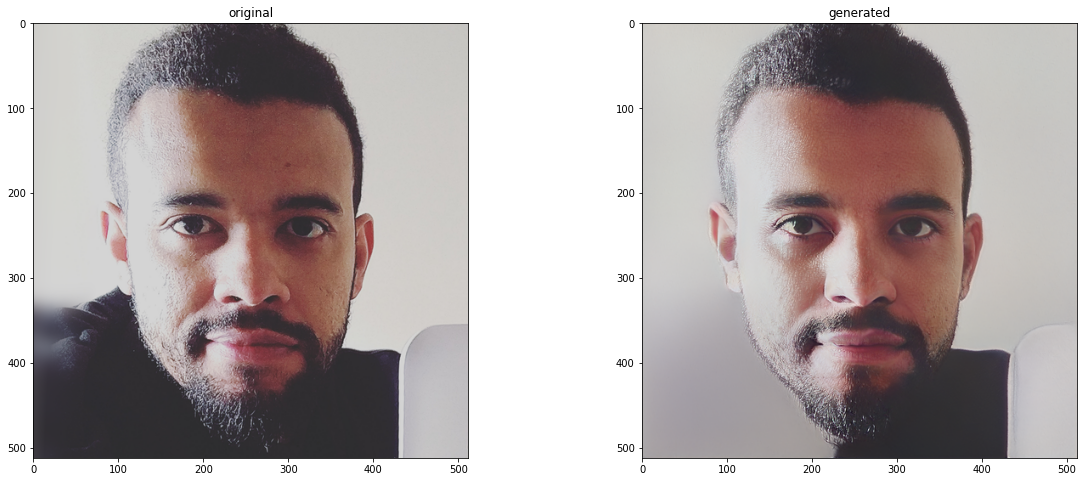

In [39]:
## Plotting the original image and the generated one

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
original = load_img("sample_faces/aligned-face.png")
imshow(original, "original")

plt.subplot(1,2,2)
generated = load_img("generated_images/aligned-face.png")
imshow(generated, "generated")

# The first image is the original face the second was generated based on the latent vector of the image. 
# Notice that the bottom right is black when in the original one it is white

## Visualize the jorney to generate the final image

You can see all imagens generated before get the final result. For that, download the generated video



In [44]:
from google.colab import files

# Download generated video
files.download("generated_images/aligned-face.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Transforming the generated image


In [ ]:
!git clone https://github.com/Puzer/stylegan-encoder.git

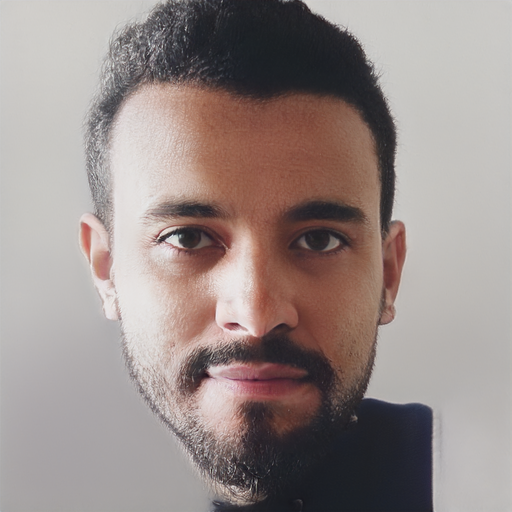

In [44]:
# # load the latents

import dnnlib.tflib as tflib
import PIL.Image
latent_vector = np.load('generated_images/aligned-face.npy')
# latent_vector = np.expand_dims(new_latent_vector,axis=0)

direction1 = np.load('stylegan-encoder/ffhq_dataset/latent_directions/age.npy')
direction2 = np.load('InterFaceGAN/boundaries/pggan_celebahq_age_boundary.npy')
direction1 = np.expand_dims(direction1,axis=0)
direction2 = np.expand_dims(direction2,axis=0)

# # combine the latents somehow... let's try an average:
new_latent_vector = 0.5*(direction1 + latent_vector)

# # combine the latents somehow... let's move to a direction
# new_latent_vector = (latent_vector + 2 * direction1)[:8]

# run the generator network to render the latents:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
images = Gs.components.synthesis.run(new_latent_vector, randomize_noise=False, **synthesis_kwargs)
display(PIL.Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').resize((512,512),PIL.Image.LANCZOS))